In [20]:
import pandas as pd
import numpy as np
import os
from pandas_datareader import data as pdr
import datetime
import warnings
import fix_yahoo_finance as yf #pip install fix_yahoo_finance
yf.pdr_override()
import matplotlib.pyplot as plt
import functools as ft
import pandas_talib as TA #git clone https://github.com/femtotrader/pandas_talib.git
import operator
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline
os.chdir("/Users/Personal/Untitled Folder 2")
warnings.filterwarnings("ignore")


# Data Retrieval

In [21]:
#Downloading the Data for S&P500 Index directly from Yahoo finance using pandas data reader

start = "2012-01-01" 
end = "2017-12-17"
SPData = pdr.get_data_yahoo("^GSPC",start,end)

[*********************100%***********************]  1 of 1 downloaded


The stock prices may be highly influenced by other major financial major indexes across the world. So i can include them as features and need to get data for them. Indexes considered are FTSE100, NIKKEI225,DJIA and NASDAQ. 

Exchange rates may also influence SP500 so we can also take USD/CNY, USD/JPY,USD/EUR and USD/GBP. 

I chose to download the data from Yahoo! and fred so that anyone is able to run the whole code without worrying about the datasets.

In [22]:
#getting all the necessary data
FTSE = pdr.get_data_yahoo("^FTSE",start,end)
NIKKEI = pdr.get_data_yahoo("^N225",start,end)
DJI = pdr.get_data_yahoo("^DJI",start,end)
NASDAQ = pdr.get_data_yahoo("^IXIC",start,end)
USDJPY = pdr.get_data_fred("DEXJPUS",start,end)
USDCNY = pdr.get_data_fred("DEXCHUS",start,end)
USDGBP = pdr.get_data_fred("DEXUSUK",start,end)
USDEUR = pdr.get_data_fred("DEXUSEU",start,end)
Gold = pdr.get_data_fred("GOLDPMGBD228NLBM",start,end)
#crude oil price - West Texas Intermediate
Oil = pdr.get_data_fred("DCOILWTICO",start,end)
Oil.columns = ['Price']
#It has null values, so dropping null values.
Oil.dropna(axis=0,how="all",inplace=True)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Data Alignment and Merging

Renaming the columns so that we can identify different Close when we merge the data

In [23]:
SPData.rename(columns = {'Close':'SP_Close'},inplace=True)
FTSE.rename(columns = {'Close':'FTSE_Close'},inplace=True)
NIKKEI.rename(columns = {'Close':'NIKKEI_Close'},inplace=True)
DJI.rename(columns = {'Close':'DJI_Close'},inplace=True)
NASDAQ.rename(columns = {'Close':'NASDAQ_Close'},inplace=True)
USDJPY.columns = ["USDJPY_Close"]
USDCNY.columns = ["USDCNY_Close"]
USDGBP.columns = ["USDGBP_Close"]
USDEUR.columns = ["USDEUR_Close"]
Gold.columns = ["Gold_Price"]
Oil.columns = ["Oil_Price"]

I drop the Adjusted Close column of FTSE, NIKKEI, DJI, NASDAQ since it would be wise to work on the Close instead of Adjusted Close. Also,since i am working on indexes Adjusted Close is equal to the Close.

In [24]:
Tickers = ["FTSE","NIKKEI","DJI","NASDAQ"]
dfs = [FTSE,NIKKEI,DJI,NASDAQ]

In [25]:
for df in dfs:
    df.drop(axis=1,columns="Adj Close",inplace=True)

In [26]:
print(FTSE)

                   Open         High          Low   FTSE_Close      Volume
Date                                                                      
2012-01-03  5572.299805  5699.899902  5572.299805  5699.899902   778529200
2012-01-04  5699.899902  5719.799805  5646.399902  5668.500000   696937800
2012-01-05  5668.500000  5689.299805  5614.399902  5624.299805   794279400
2012-01-06  5624.299805  5682.799805  5623.399902  5649.700195   705018100
2012-01-09  5649.700195  5673.799805  5604.600098  5612.299805   785646100
2012-01-10  5612.299805  5711.899902  5612.299805  5696.700195   865034500
2012-01-11  5696.700195  5700.799805  5644.799805  5670.799805   893410000
2012-01-12  5670.799805  5699.600098  5640.299805  5662.399902  1382096100
2012-01-13  5662.399902  5709.200195  5583.500000  5636.600098  1318584400
2012-01-16  5636.600098  5662.899902  5609.899902  5657.399902   672822900
2012-01-17  5657.399902  5724.399902  5657.399902  5694.000000  1232187300
2012-01-18  5694.000000  

# Merging Data in one single frame

In [27]:
#List of data to be merged
Temp = [SPData,FTSE["FTSE_Close"],NIKKEI["NIKKEI_Close"],DJI["DJI_Close"],NASDAQ["NASDAQ_Close"],
USDJPY["USDJPY_Close"],USDCNY["USDCNY_Close"],USDGBP["USDGBP_Close"],USDEUR["USDEUR_Close"],Gold["Gold_Price"],Oil["Oil_Price"]]

In [28]:
MergingList = [Temp[i].to_frame() for i in range(1,len(Temp))]
MergingList.insert(0,SPData)

In [29]:
Data = ft.reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True),MergingList)

In [30]:
Data.dropna(inplace=True)

In [31]:
Data.head()

,Open,High,Low,SP_Close,Adj Close,Volume,FTSE_Close,NIKKEI_Close,DJI_Close,NASDAQ_Close,USDJPY_Close,USDCNY_Close,USDGBP_Close,USDEUR_Close,Gold_Price,Oil_Price
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,-702387296,5668.500000,8560.110352,12418.419922,2648.360107,76.68,6.2941,1.5638,1.2930,1613.0,103.22
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,20982704,5624.299805,8488.709961,12415.700195,2669.860107,77.18,6.3013,1.5480,1.2783,1599.0,101.81
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,-638137296,5649.700195,8390.349609,12359.919922,2674.219971,77.06,6.3088,1.5431,1.2723,1616.5,101.56
2012-01-10,1280.770020,1296.459961,1280.770020,1292.079956,1292.079956,-73007296,5696.700195,8422.259766,12462.469727,2702.500000,76.84,6.3141,1.5489,1.2782,1637.0,102.24
2012-01-11,1292.020020,1293.800049,1285.410034,1292.479980,1292.479980,-326847296,5670.799805,8447.879883,12449.450195,2710.760010,76.90,6.3149,1.5325,1.2686,1634.5,100.89


In [75]:
print(Data)

                   Open         High          Low     SP_Close    Adj Close  \
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-10  1280.770020  1296.459961  1280.770020  1292.079956  1292.079956   
2012-01-11  1292.020020  1293.800049  1285.410034  1292.479980  1292.479980   
2012-01-12  1292.479980  1296.819946  1285.770020  1295.500000  1295.500000   
2012-01-13  1294.819946  1294.819946  1277.579956  1289.089966  1289.089966   
2012-01-17  1290.219971  1303.000000  1290.219971  1293.670044  1293.670044   
2012-01-18  1293.650024  1308.109985  1290.989990  1308.040039  1308.040039   
2012-01-19  1308.069946  1315.489990  1308.069946  1314.500000  1314.500000   
2012-01-20  1314.489990  1315.380005  1309.170044  1315.380005  1315.380005   
2012-01-23  1315.290039  1322.280029  1309.890015  1

# Next we perform a correlation matrix of SP_Close data with that of FTSE, NASDAQ, DJI, NIKKEI to see if there is any positive correlation

In [32]:
returns = Data[['SP_Close','FTSE_Close','NASDAQ_Close','DJI_Close','NIKKEI_Close']].pct_change()

In [33]:
returns.head()

,SP_Close,FTSE_Close,NASDAQ_Close,DJI_Close,NIKKEI_Close
2012-01-04,NaN,NaN,NaN,NaN,NaN
2012-01-05,0.002944,-0.007798,0.008118,-0.000219,-0.008341
2012-01-06,-0.002537,0.004516,0.001633,-0.004493,-0.011587
2012-01-10,0.011167,0.008319,0.010575,0.008297,0.003803
2012-01-11,0.000310,-0.004547,0.003056,-0.001045,0.003042


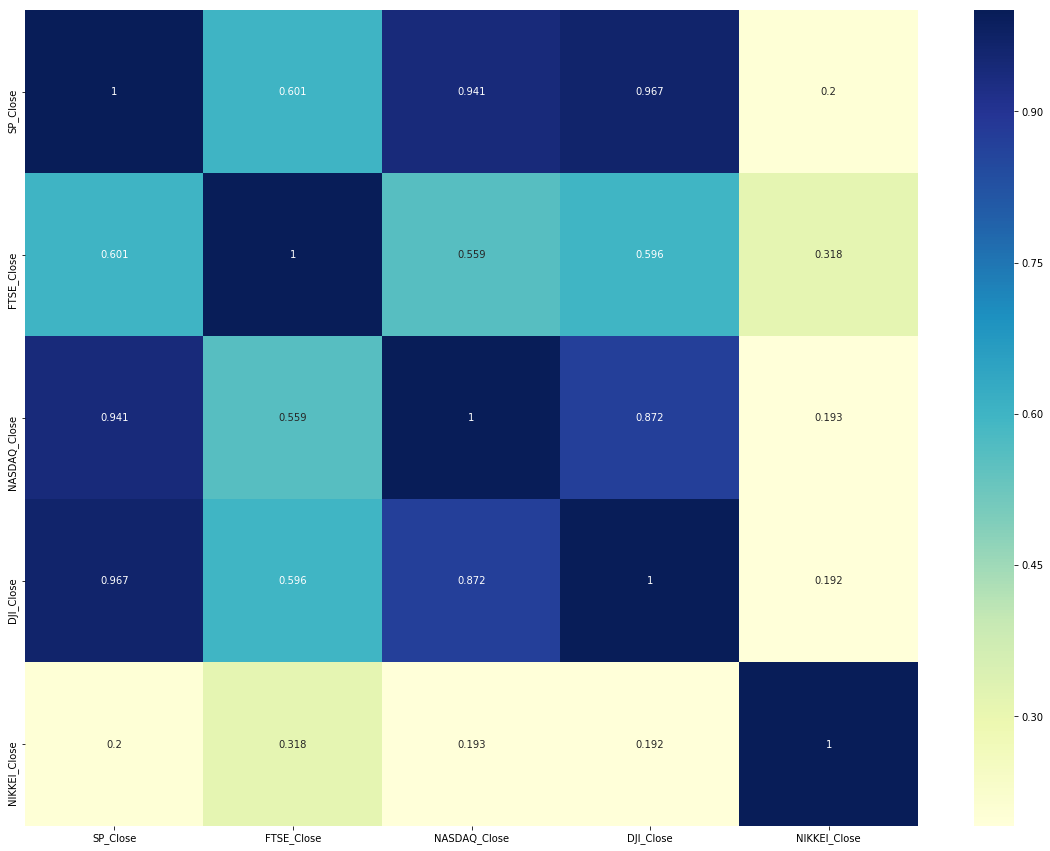

In [34]:
plt.subplots(figsize=(20,15))
sns.heatmap(returns.corr(),annot=True,fmt=".3g",cmap='YlGnBu')

# Next we perform a correlation matrix of SP_Close data with that of exchange rates and commodity prices to see if there is any positive correlation


In [35]:
returns_fx = Data[['SP_Close','USDJPY_Close','USDCNY_Close','USDGBP_Close','USDEUR_Close','Gold_Price','Oil_Price']].pct_change()

In [36]:
returns_fx.head()

,SP_Close,USDJPY_Close,USDCNY_Close,USDGBP_Close,USDEUR_Close,Gold_Price,Oil_Price
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,0.002944,0.006521,0.001144,-0.010104,-0.011369,-0.008679,-0.013660
2012-01-06,-0.002537,-0.001555,0.001190,-0.003165,-0.004694,0.010944,-0.002456
2012-01-10,0.011167,-0.002855,0.000840,0.003759,0.004637,0.012682,0.006696
2012-01-11,0.000310,0.000781,0.000127,-0.010588,-0.007511,-0.001527,-0.013204


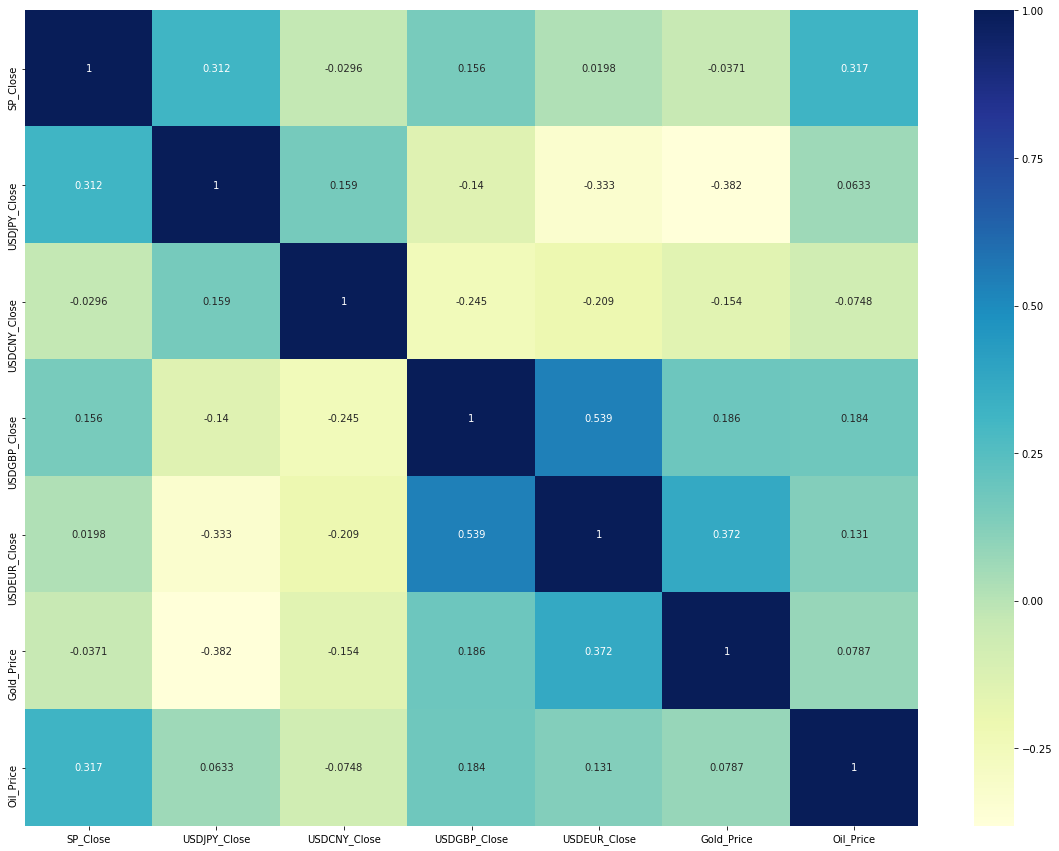

In [37]:
plt.subplots(figsize=(20,15))
sns.heatmap(returns_fx.corr(),annot=True,fmt=".3g",cmap='YlGnBu')

In [38]:
DataTemp = Data.copy(deep=True)

# Feature Generation


Technical indicators are used extensively in the industry and they speak quite well about the trend. People have successfully traded using technical indicators so I decided to use several technical indicators in my project.

In [39]:
def RSI(close, period):
    delta = close.diff().dropna()
    up = delta * 0
    down = up.copy()
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]
    
    up[up.index[period-1]] = np.mean( up[:period] ) #first value is sum of avg gains
    up = up.drop(up.index[:(period-1)])
    down[down.index[period-1]] = np.mean( down[:period] ) #first value is sum of avg losses
    down = down.drop(down.index[:(period-1)])
    
    rs = pd.stats.moments.ewma(up, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(down, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)

In [40]:
DataTemp["RSI"] = RSI(DataTemp["SP_Close"],14)

In [41]:
def CCI(close, high, low, n, constant): 
 TP = (high + low + close) / 3 
 CCI = pd.Series((TP - pd.rolling_mean(TP, n)) / (constant * pd.rolling_std(TP, n)), name = 'CCI_' + str(n)) 
 return CCI

In [42]:
DataTemp["CCI_20"] = CCI(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],20,0.015)
DataTemp["CCI_10"] = CCI(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],10,0.015)

In [43]:
def ACCDIST(Close, High, Low, Volume, n):  
    ad = (2 * Close - High - Low) / (High - Low) * Volume  
    M = ad.diff(n - 1)  
    N = ad.shift(n - 1)  
    ROC = M / N  
    AD = pd.Series(ROC, name = 'Acc/Dist_ROC_' + str(n))    
    return AD

In [44]:
DataTemp["ACCDIST"] = ACCDIST(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],DataTemp["Volume"],10)

In [45]:
def MOM(Close, n):  
    M = pd.Series(Close.diff(n), name = 'Momentum_' + str(n))    
    return M

In [46]:
DataTemp["MOM_3"] = MOM(DataTemp["SP_Close"],3)
DataTemp["MOM_5"] = MOM(DataTemp["SP_Close"],5)

In [47]:
def ROC(close, n):  
    M = close.diff(n - 1)  
    N = close.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

In [48]:
DataTemp["ROC_3"] = ROC(DataTemp["SP_Close"],3)
DataTemp["ROC_5"] = ROC(DataTemp["SP_Close"],5)
DataTemp["ROC_7"] = ROC(DataTemp["SP_Close"],7)

In [49]:
def MA(Close,n):
    MA = pd.Series(pd.rolling_mean(Close,n),name='MA_'+str(n))
    return MA

In [50]:
DataTemp["MA_10"] = MA(DataTemp["SP_Close"],10)
DataTemp["MA_5"] = MA(DataTemp["SP_Close"],5)

In [51]:
def EMA(close, n):  
    EMA = pd.Series(pd.ewma(close, span = n, min_periods = n - 1), name = 'EMA_' + str(n))    
    return EMA

In [52]:
DataTemp["EMA_10"] = EMA(DataTemp["SP_Close"],10)
DataTemp["EMA_7"] = EMA(DataTemp["SP_Close"],7)

In [53]:
def STDDEV(close, n):  
    stddev = pd.Series(pd.rolling_std(close, n), name = 'STD_' + str(n)) 
    return stddev

In [54]:
DataTemp["STDDEV_10"] = STDDEV(DataTemp["SP_Close"],10)
DataTemp["STDDEV_21"] = STDDEV(DataTemp["SP_Close"],20)

I will be working with 3 Target variables which will be described shortly as follows.

Target 1: Close(i+1) - Close(i)

Target 2: Open(i+1) - Open(i)

Target 3: if Return > 0.0015 -> +1 else -1

In [55]:
#Function to create Target 3
def target_label(x):
    if x>0.0015:
        return 1
    else:
        return -1

In [56]:
DataTemp["Target1"] = np.sign(DataTemp["SP_Close"].diff()).shift(-1)
DataTemp["Target2"] = np.sign(DataTemp["Open"].diff()).shift(-1)
DataTemp["Target3"] = DataTemp["SP_Close"].pct_change().apply(target_label).shift(-1)
DataTemp.ix[DataTemp.Target2==0, 'Target2'] = 1

Since we want to trade at the open of the market. We cannot use the features such as low,high, volume, etc. but we can definitely use the returns of the other indices since they trade before US market and will affect US market

In [57]:
DataTemp["Open_Change"] = DataTemp["Open"].pct_change()
DataTemp["High_Change"] = DataTemp["High"].pct_change()
DataTemp["Volume_Change"] = DataTemp["Volume"].pct_change()
DataTemp["Low_Change"] = DataTemp["Low"].pct_change()

In [58]:
#Calculating Returns
ReturnsList = [i for i in DataTemp.columns if any(['_Close' in i,'_Price' in i])]
for i in ReturnsList:
    DataTemp[i.split("_")[0]+"_Returns"] = DataTemp[i].pct_change()
Drop = [i for i in DataTemp.columns if any(["_Price" in i,"_Close" in i])]
DataTemp.drop(Drop,axis=1,inplace=True)

In [59]:
DataTemp.dropna(inplace=True)
ColsList = list(DataTemp.columns)
ColsList.pop(ColsList.index("Target1"))
ColsList.pop(ColsList.index("Target2"))
ColsList.pop(ColsList.index("Target3"))
DataTemp = DataTemp[ColsList+["Target1"]+["Target2"]+["Target3"]]

In [60]:
DataTemp.dropna(inplace=True)

In [61]:
DataTemp.head()

,Open,High,Low,Adj Close,Volume,RSI,CCI_20,CCI_10,ACCDIST,MOM_3,...,NASDAQ_Returns,USDJPY_Returns,USDCNY_Returns,USDGBP_Returns,USDEUR_Returns,Gold_Returns,Oil_Returns,Target1,Target2,Target3
2012-02-02,1324.239990,1329.189941,1321.569946,1325.540039,-174047296,75.261074,88.093634,107.745954,-0.980872,12.530029,...,0.004006,0.000263,-0.000935,-0.002271,-0.000911,0.006322,-0.013008,1.0,1.0,1.0
2012-02-03,1326.209961,1345.339966,1326.209961,1344.900024,313582704,80.866663,126.586583,152.699431,40.594363,32.489990,...,0.016079,0.005386,0.000159,-0.002150,-0.004633,-0.009709,0.014944,-1.0,1.0,-1.0
2012-02-06,1344.319946,1344.359985,1337.520020,1344.329956,-915267296,80.289754,125.171888,122.212413,1.051384,20.239990,...,-0.001263,0.000000,0.001476,0.003359,0.001831,-0.008651,-0.009305,1.0,1.0,1.0
2012-02-07,1344.329956,1349.239990,1335.920044,1347.050049,-552507296,80.986758,121.228180,102.378772,-5.084530,21.510010,...,0.000720,0.004442,-0.001172,0.003727,0.008682,0.002909,0.017133,1.0,1.0,1.0
2012-02-08,1347.040039,1351.000000,1341.949951,1349.959961,-198237296,81.731041,119.029791,94.003671,0.308344,5.059937,...,0.004056,0.000260,-0.001713,-0.004468,0.000680,0.012761,0.002537,1.0,1.0,-1.0


In [62]:
DataTemp.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI', 'CCI_20', 'CCI_10',
       'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7', 'MA_10', 'MA_5',
       'EMA_10', 'EMA_7', 'STDDEV_10', 'STDDEV_21', 'Open_Change',
       'High_Change', 'Volume_Change', 'Low_Change', 'SP_Returns',
       'FTSE_Returns', 'NIKKEI_Returns', 'DJI_Returns', 'NASDAQ_Returns',
       'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns', 'USDEUR_Returns',
       'Gold_Returns', 'Oil_Returns', 'Target1', 'Target2', 'Target3'],
      dtype='object')

In [63]:
DataTemp.columns[:-3]

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI', 'CCI_20', 'CCI_10',
       'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7', 'MA_10', 'MA_5',
       'EMA_10', 'EMA_7', 'STDDEV_10', 'STDDEV_21', 'Open_Change',
       'High_Change', 'Volume_Change', 'Low_Change', 'SP_Returns',
       'FTSE_Returns', 'NIKKEI_Returns', 'DJI_Returns', 'NASDAQ_Returns',
       'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns', 'USDEUR_Returns',
       'Gold_Returns', 'Oil_Returns'],
      dtype='object')

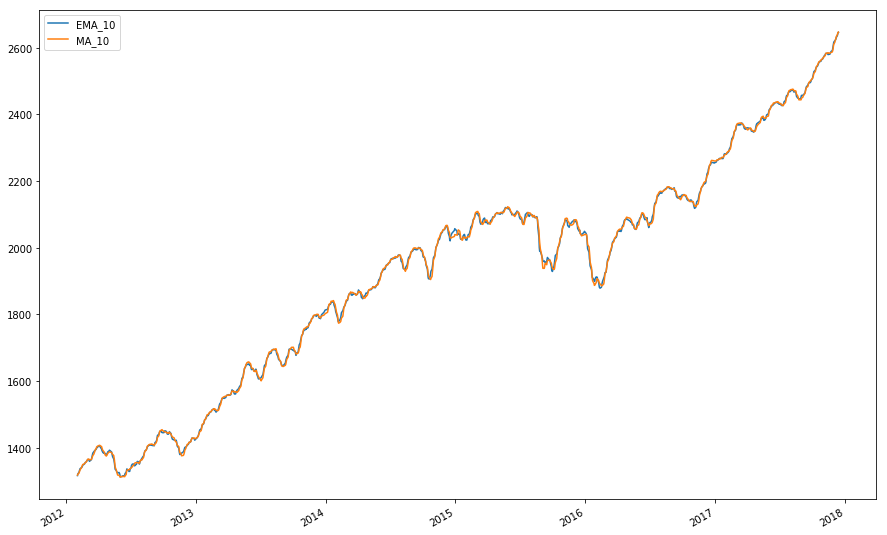

In [64]:
DataTemp[['EMA_10','MA_10']].plot(legend=True, figsize=(15,10))

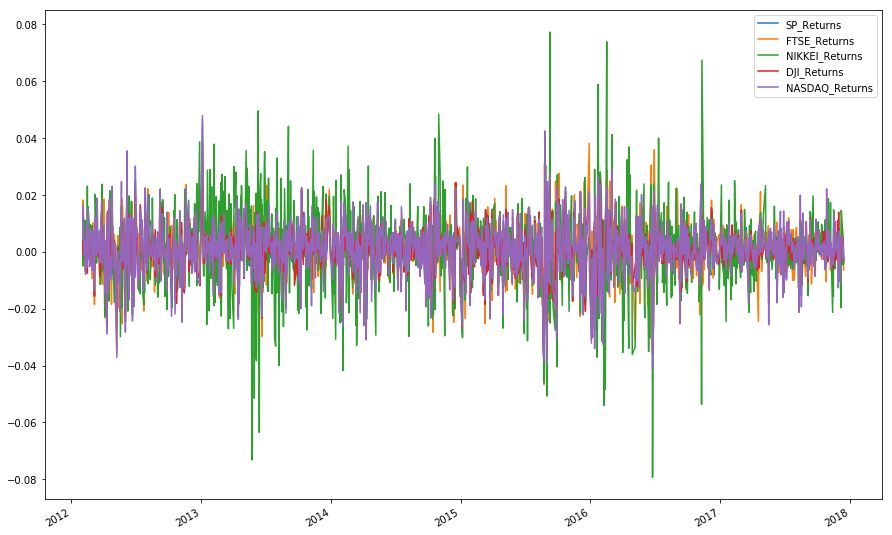

In [65]:
DataTemp[['SP_Returns', 'FTSE_Returns','NIKKEI_Returns', 'DJI_Returns', 'NASDAQ_Returns']].plot(legend=True, figsize=(15,10))

# Defining the ML models to be used

In [66]:
#creating helper functions to use them for classification
from sklearn.svm import LinearSVC
def LinearSVM(X_train, y_train, X_test, y_test, parameters):
    clf=LinearSVC(loss="hinge",C=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, y_train, X_test, y_test, parameters):
    clf = RandomForestClassifier(n_estimators=parameters[0],n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.linear_model import LogisticRegression
def LogRegress(X_train, y_train, X_test, y_test, parameters):
    clf = LogisticRegression(C=parameters[0])
    clf.fit(X_train,y_train)
    accuracy = clf.score(X_test,y_test)
    return clf, accuracy

from sklearn import neighbors
def KNN(X_train, y_train, X_test, y_test, parameters):
    clf = neighbors.KNeighborsClassifier(n_neighbors=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.naive_bayes import GaussianNB
def GNB(X_train, y_train, X_test, y_test):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.ensemble import AdaBoostClassifier
def AdaBoost(X_train, y_train, X_test, y_test, parameters):
    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators = n, learning_rate = l)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

# Cross Validation and implementation of ROC (Receiver Operating Characteristics ) curve

In [67]:
def mask(df, features,y,start_test):
    '''
    To separate dataset and get X_train, X_test, y_train, y_test
    df=dataframe
    y = target 1 , 2 or 3
    start_test = 2017-01-01, i.e. split data until 2017-01-01 as training and the remaining as test 
    '''
    X=df[features]
    y=df[y]
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    return X_train, y_train, X_test, y_test 

def classifier(X_train, y_train, X_test, y_test, method, parameters):
    '''
    To call different classifiers
    '''
    if method == 'RF':   
        return RandomForest(X_train, y_train, X_test, y_test, parameters)
    elif method == 'SVM':   
        return LinearSVM(X_train, y_train, X_test, y_test, parameters)
    elif method == 'LOG':
        return LogRegress(X_train, y_train, X_test, y_test, parameters)
    elif method == 'KNN':
        return KNN(X_train, y_train, X_test, y_test, parameters)
    elif method == 'GNB':
        return GNB(X_train, y_train, X_test, y_test)
    elif method == 'ADA':
        return AdaBoost(X_train, y_train, X_test, y_test, parameters)


#In time series, we cannot shuffle the dataset, we have to incrementally validate. 
#In the below function we split the data into k folds. As we move forward we train our data on all the previous data 
#available. So for example we will use the first fold on first iteration and test on fold 2. For second
#iteration we will train our model on fold 1+ fold2 and test on fold 3 and so on. So as we move forward we make
#sure that all past information is incorporated
def CV(X_train, y_train, folds, method, parameter):
    '''
    To get the average score of cross validation
    
    '''
    k = int(np.floor(float(X_train.shape[0])/folds))
    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        split = float(i-1)/i
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]        
        y_tr = output[:index]
        X_te = data[(index+1):]
        y_te = output[(index+1):]        
        acc[i-2] = classifier(X_tr, y_tr, X_te, y_te, method, parameter)[1]
    return acc.mean()  

#the below function searches for the best parameter
def SearchGrid(X_train, y_train, folds, method, grid):
    '''
    To get the best parameters for a given classifier
    '''
    param = list(grid.keys())
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = CV(X_train, y_train, folds, method, parameters)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.items(), key=operator.itemgetter(0), reverse=True)          
        return final[0]
    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = CV(X_train, y_train, folds,method, parameters)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.items(), key=operator.itemgetter(0), reverse=True)
        return final[0]
 
#this function below searches for the best classifier
def cv_optimize(X_train, y_train, X_test, y_test, folds, method, grid):
    '''
    Return to a best classifier
    '''
    if grid==[]:
        best=classifier(X_train, y_train, X_test, y_test, method, grid)
    else:
        param=SearchGrid(X_train, y_train, folds, method, grid)[1]
        best=classifier(X_train, y_train, X_test, y_test, method, param)
    return best[0]

In [68]:
#plot ROC curve
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.2,)
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [69]:
predict=datetime.datetime(2017,1,1)

# Performance Evaluation

# Label 1: Close

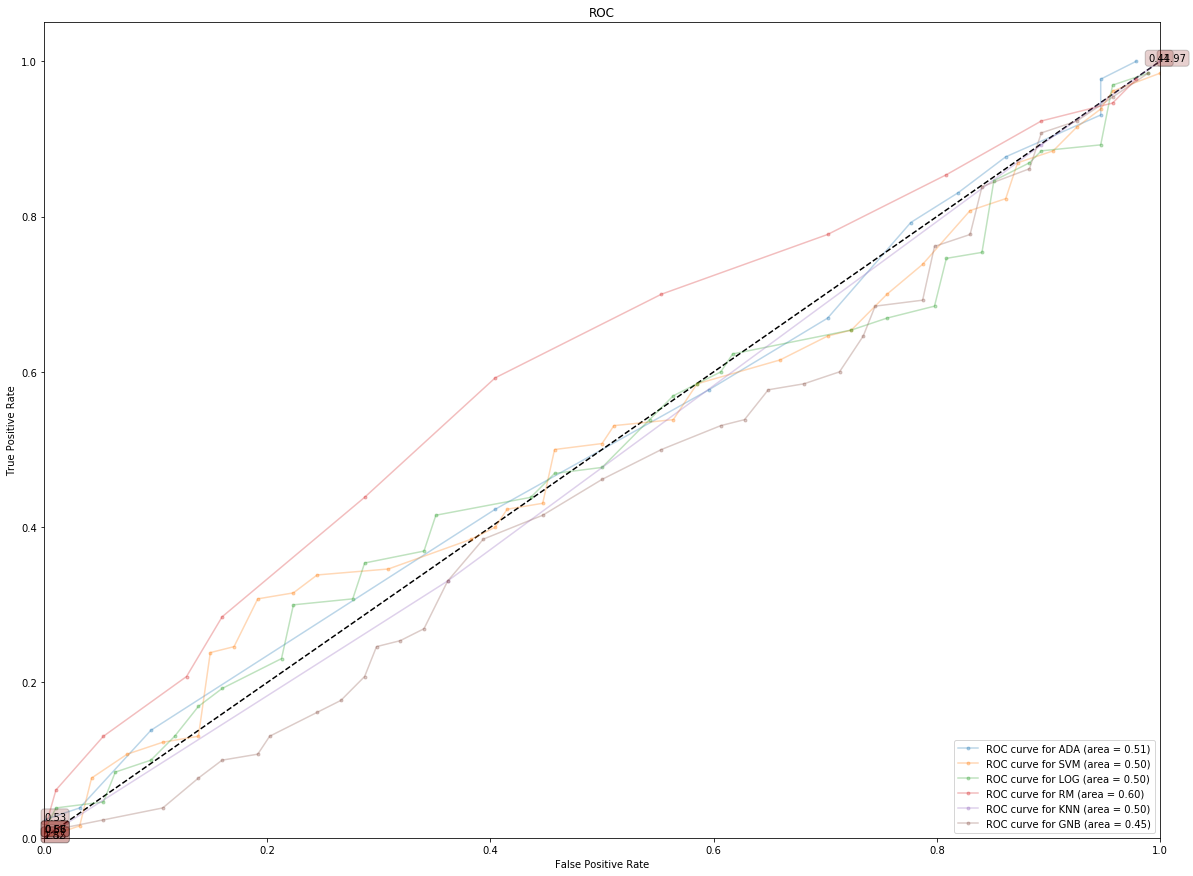

In [70]:
X_train, y_train, X_test, y_test=mask(DataTemp,['Open', 'High', 'Low', 'Volume', 'RSI', 'CCI_20',
       'CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10',
       'STDDEV_21','Open_Change', 'High_Change', 'Volume_Change',
       'Low_Change', 'SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target1', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

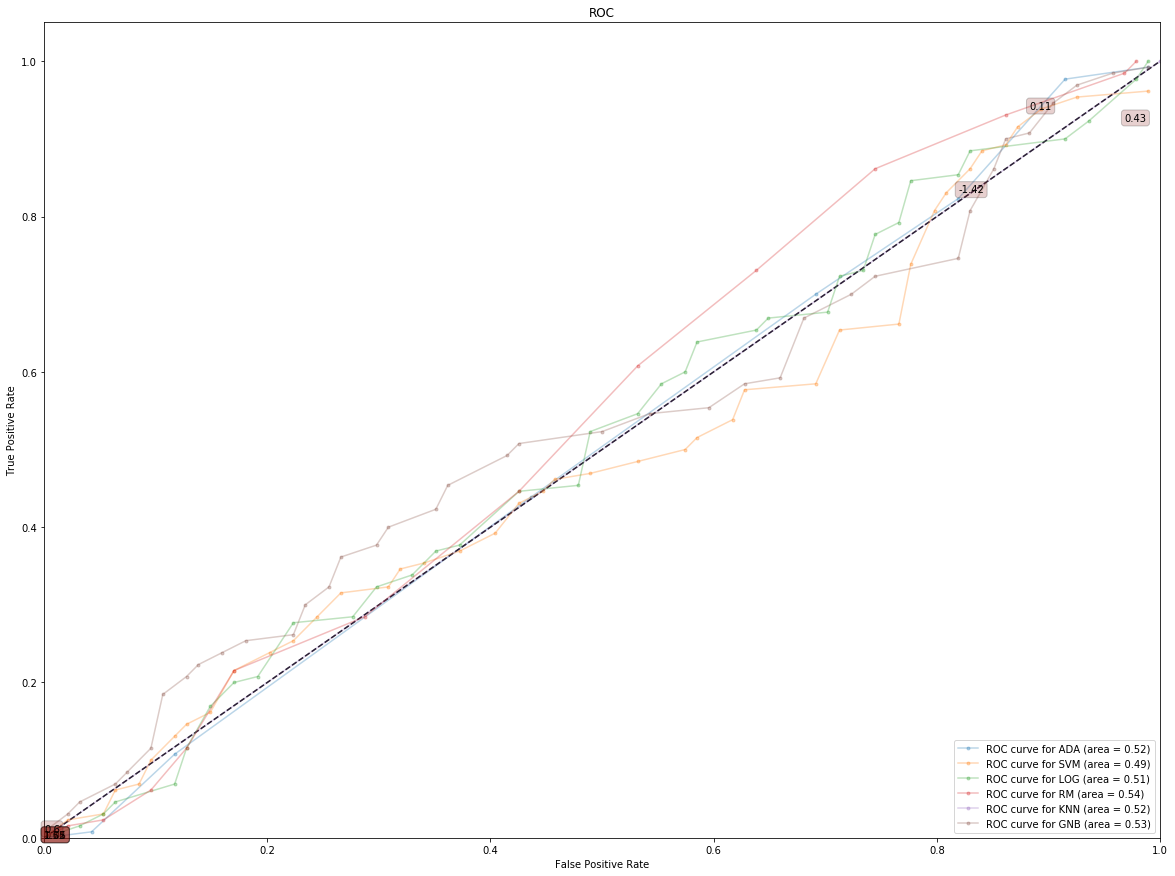

In [124]:
X_train, y_train, X_test, y_test=mask(DataTemp,['RSI', 'CCI_20','CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10','STDDEV_21'],'Target1', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

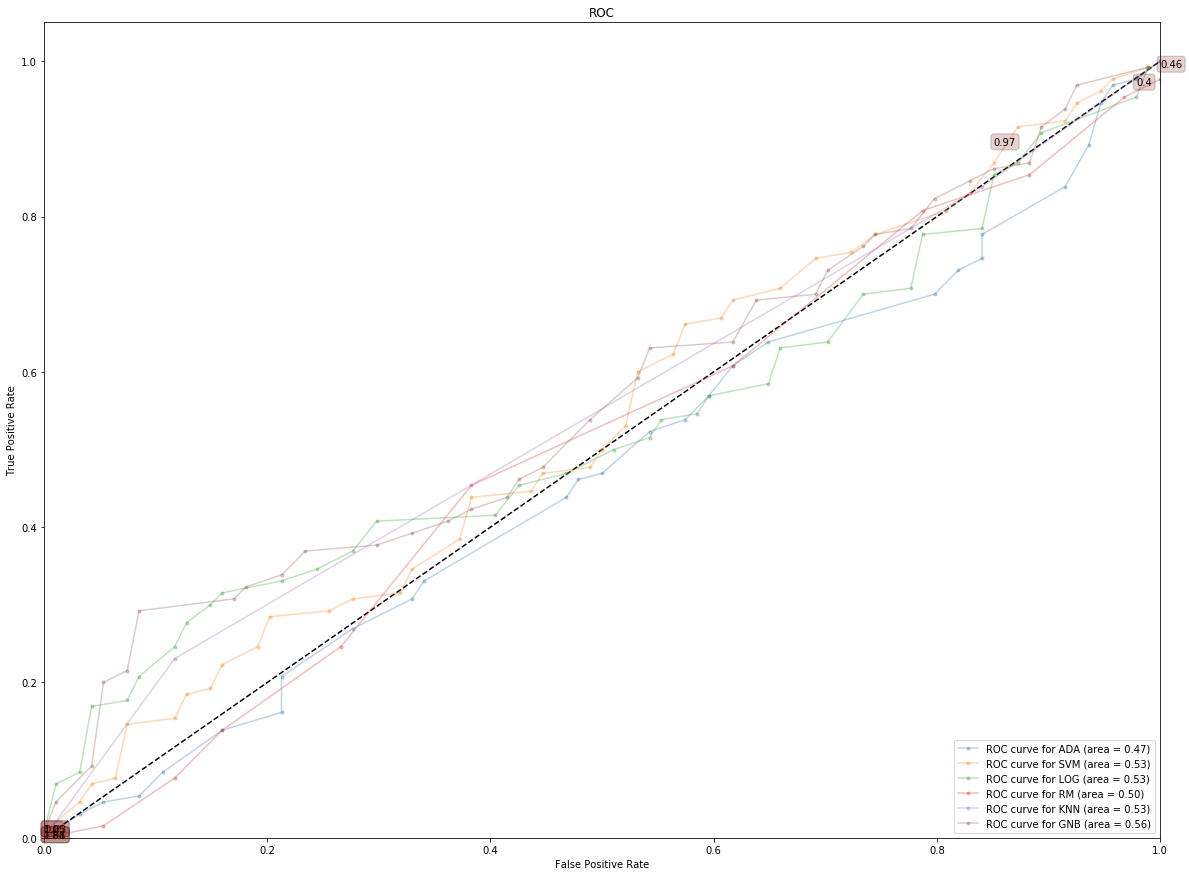

In [78]:
X_train, y_train, X_test, y_test=mask(DataTemp,['SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target1', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

# Lable 2 : Open

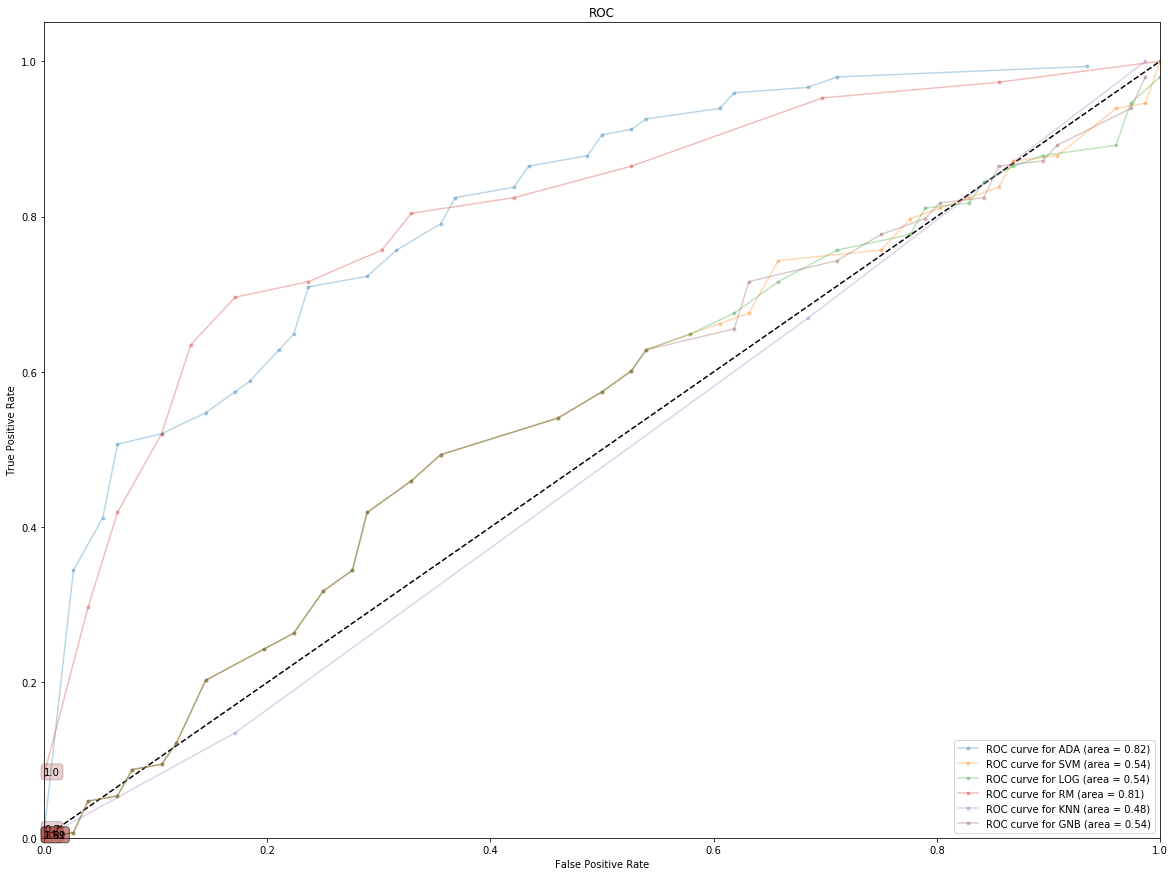

In [126]:
X_train, y_train, X_test, y_test=mask(DataTemp,['Open', 'High', 'Low', 'Volume', 'RSI', 'CCI_20',
       'CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10',
       'STDDEV_21','Open_Change', 'High_Change', 'Volume_Change',
       'Low_Change', 'SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target2', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

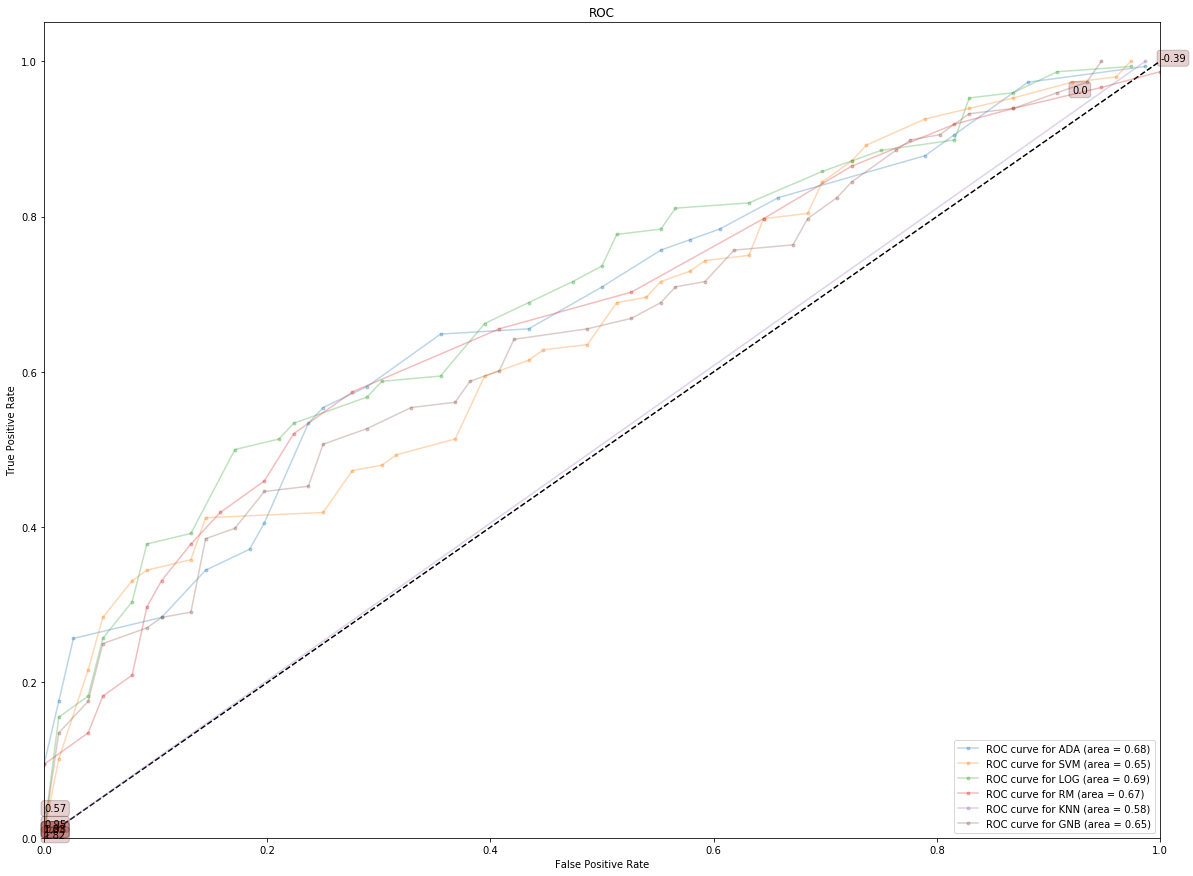

In [127]:
X_train, y_train, X_test, y_test=mask(DataTemp,['RSI', 'CCI_20','CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10','STDDEV_21'],'Target2', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

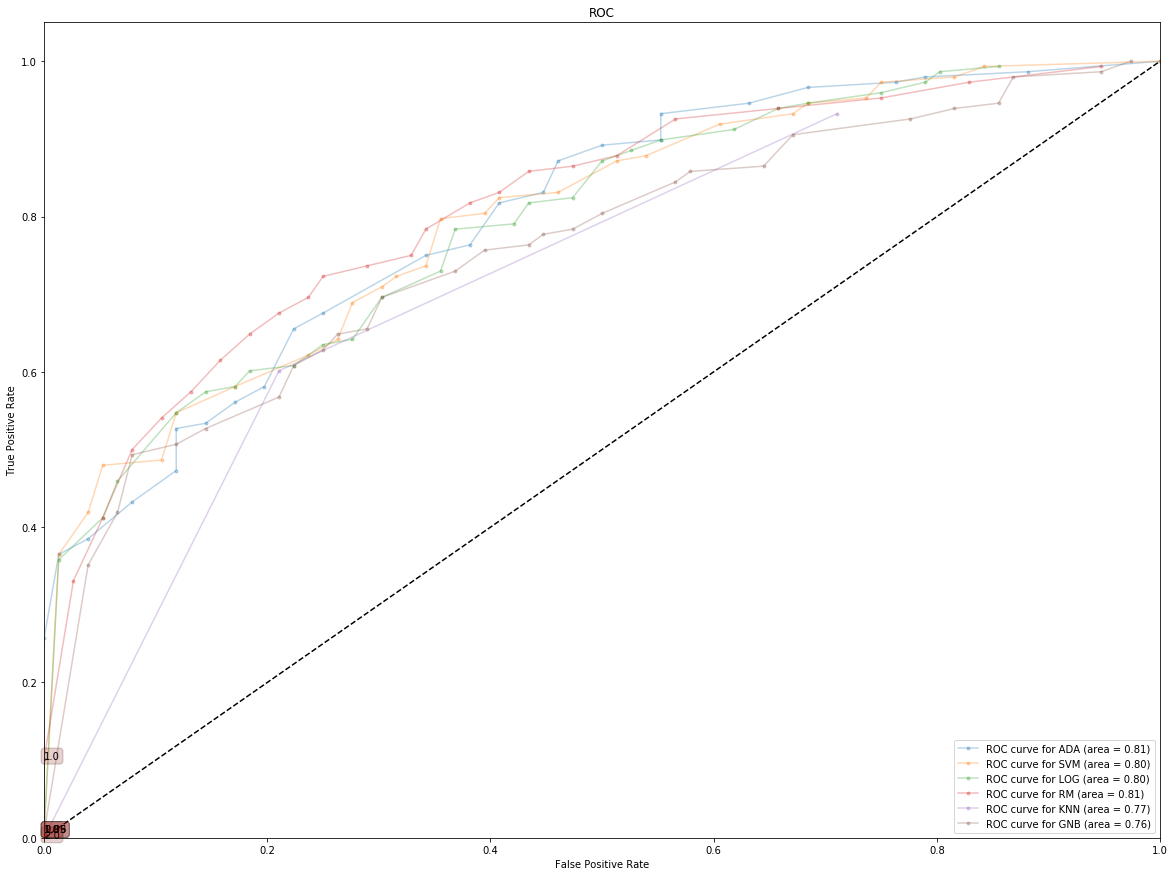

In [73]:
X_train, y_train, X_test, y_test=mask(DataTemp,['SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target2', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

# Label 3: Returns

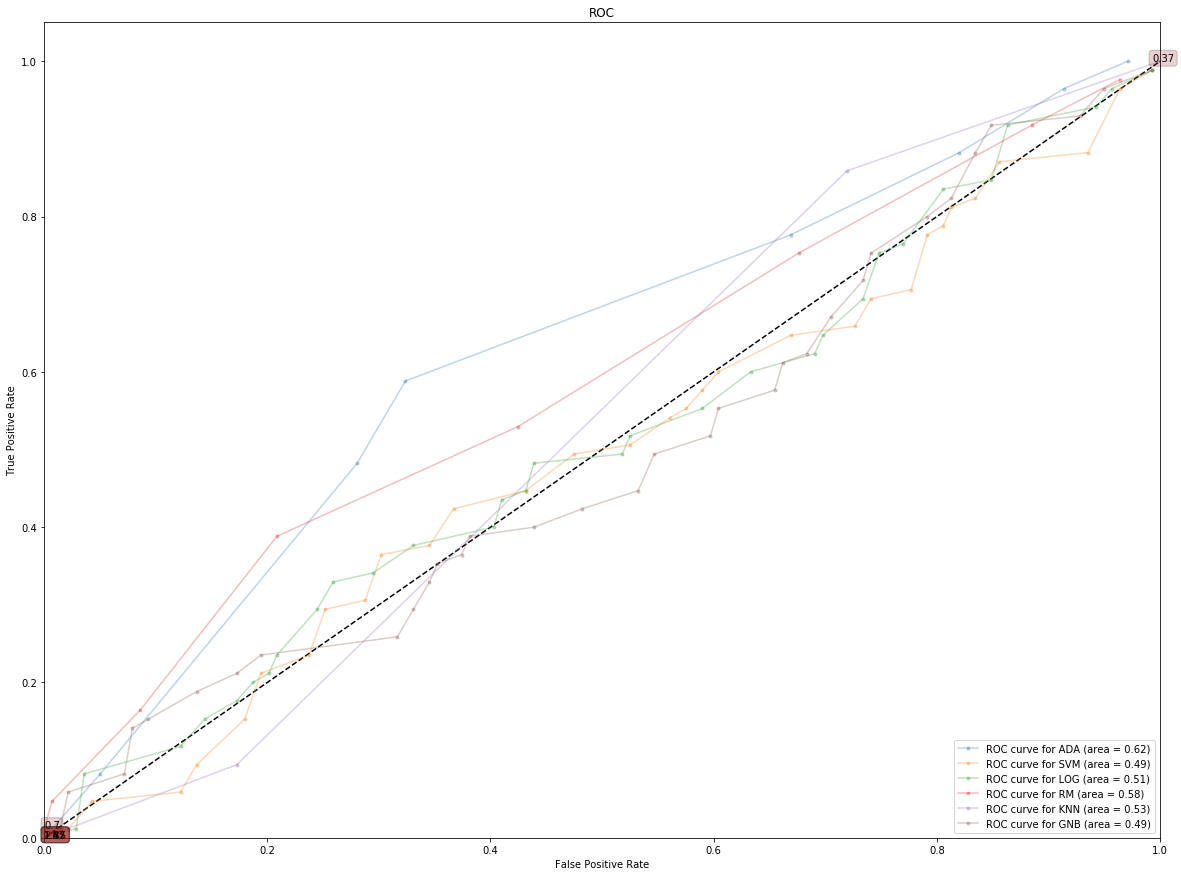

In [72]:
X_train, y_train, X_test, y_test=mask(DataTemp,['Open', 'High', 'Low', 'Volume', 'RSI', 'CCI_20',
       'CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10',
       'STDDEV_21','Open_Change', 'High_Change', 'Volume_Change',
       'Low_Change', 'SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target3', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

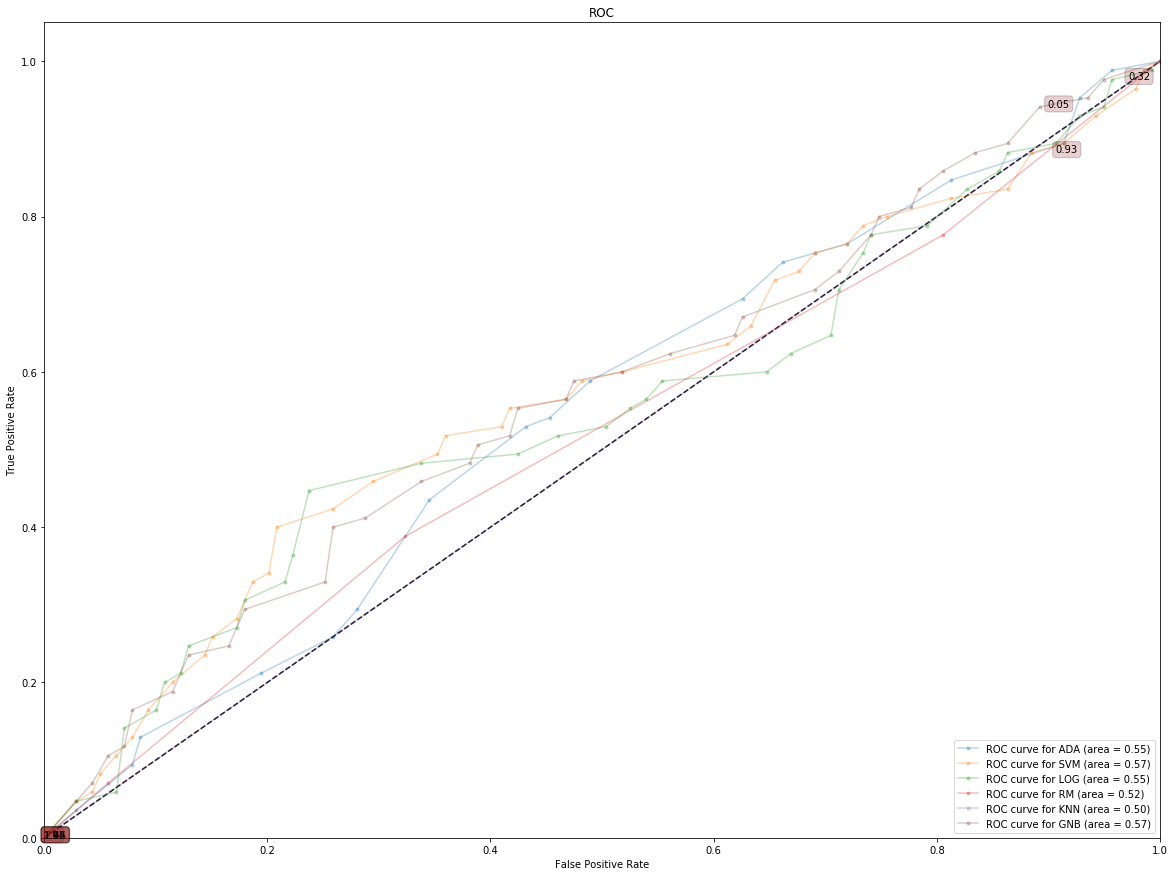

In [130]:
X_train, y_train, X_test, y_test=mask(DataTemp,['RSI', 'CCI_20','CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5','EMA_10', 'EMA_7', 'STDDEV_10','STDDEV_21'],'Target3', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

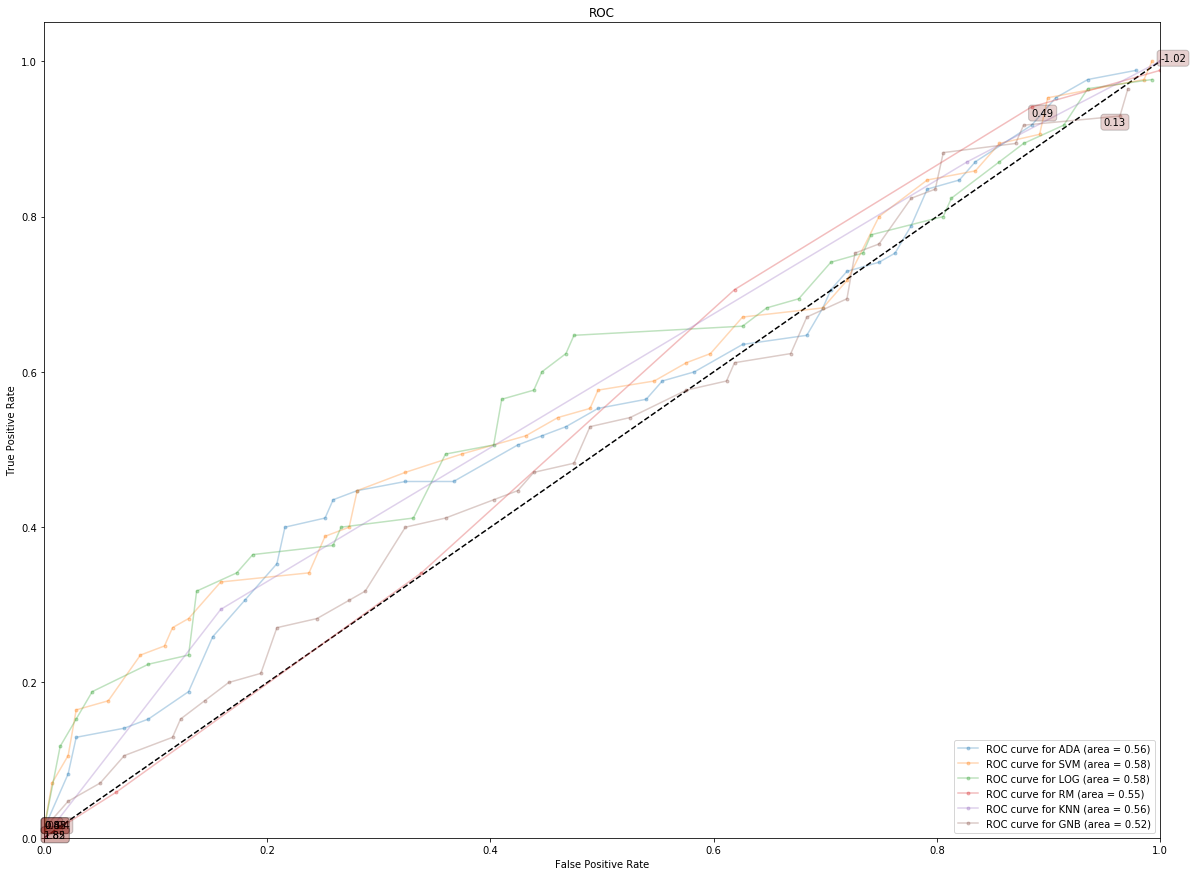

In [74]:
X_train, y_train, X_test, y_test=mask(DataTemp,['SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns'],'Target3', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
plt.subplots(figsize=(20,15))
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)